# Height and Weight of Boys Ages 5-17 Across Japan

# Introduction

Every year across Japan, measurement sessions are required by the government to be held at elementary schools in every region from ages 5-17, measuring each child's height and weight. **Using this data, we will be predicting the age of the child based on given height and weight in boys.** We will be splitting the dataset into a training and testing set to test the accuracy of the model of predicting the age from the testing data’s height and weight of boys 5-17 in Japan. 

# Preliminary Exploratory Analysis

In [70]:
install.packages("janitor")
install.packages("cowplot")
library(tidyverse)
library(janitor)
library(repr)
library(tidymodels)
library(cowplot)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



#### 1. Demonstration that the data set `man.csv` can be read into R 

In [3]:
man_data <- read_csv("man.csv")
head(man_data)

Rows: 624 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): category
dbl (5): year, height_average, height_standard deviation, body weight _avera...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


year,category,height_average,height_standard deviation,body weight _average,body weight _standard deviation
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5,national,111.0,4.87,19.3,2.79
5,Hokkaido,111.3,4.81,19.3,2.83
5,Aomori,111.8,4.87,19.9,2.78
5,Iwate,111.0,5.08,19.6,3.02
5,Miyagi,111.3,4.90,19.7,3.04
5,Akita,112.3,5.08,19.9,3.16


### 2. Data wrangling and cleaning 
1. clean the column names using `clean_names` to make column name only contain lower case letters and underscores.
2. remove the unused columns (variables): `category`, `height_standard_deviation`, `body_weight _standard_deviation`.
3. change the column (variable) `year` to `age`.

The above steps have made sure the clean_man_data is currently in a tidy format. 

In [5]:
clean_man_data <- man_data |>
        clean_names() |>
        select(-category, -height_standard_deviation, -body_weight_standard_deviation) |>
        rename("age" = "year")
head(clean_man_data)

age,height_average,body_weight_average
<dbl>,<dbl>,<dbl>
5,111.0,19.3
5,111.3,19.3
5,111.8,19.9
5,111.0,19.6
5,111.3,19.7
5,112.3,19.9


#### 3. Initial split of our data set `clean_man_data` (to training and testing data) 

In [52]:
man_split <- initial_split(clean_man_data, prop = 0.75, starta = age)
man_train <- training(man_split)
man_test <- testing(man_split)

# take a look to make sure it looks good 
head(man_train)
head(man_test)

age,height_average,body_weight_average
<dbl>,<dbl>,<dbl>
11,147.1,41.9
12,153.8,46.7
7,122.9,24.7
11,145.8,41.0
14,164.2,54.2
15,167.9,57.5


age,height_average,body_weight_average
<dbl>,<dbl>,<dbl>
5,111.5,19.5
5,111.0,19.7
5,111.7,19.5
5,111.7,19.4
5,110.4,19.2
5,110.7,19.0


### 4. Preliminary summary tables of the training data 
1. Summarize the number of observations (rows) for each age in the dataframe `number_observation_by_age`.
2. Report the means and standard deviations for each predictor variables weight and height in the dataframe `summary_predictors`.
3. Calculate the number of rows that have missing values using `complete.cases`. We found that there is **no missing value** in our training set.

In [59]:
number_obersvation_by_age  <- man_train |>
                    group_by(age) |>
                    summarize(count = n()) 

summary_predictors <- man_train |>
                pivot_longer(cols = height_average:body_weight_average,
                            names_to = "predictors", 
                            values_to = "value") |>
                group_by(predictors) |>
                summarize(mean = mean(value, na.rm = TRUE), 
                          SD = sd(value, na.rm = TRUE))
missing_rows <- man_train |>
                    filter(complete.cases(man_train) == FALSE) |>
                    nrow() 

In [60]:
number_obersvation_by_age
summary_predictors
missing_rows # here the missing_rows is 0 

age,count
<dbl>,<int>
5,29
6,39
7,34
8,37
9,36
10,36
11,35
12,37
13,33


predictors,mean,SD
<chr>,<dbl>,<dbl>
body_weight_average,41.43825,14.94241
height_average,145.74573,20.32604


[1] 0

### 5. Preliminary visualization of the training data 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


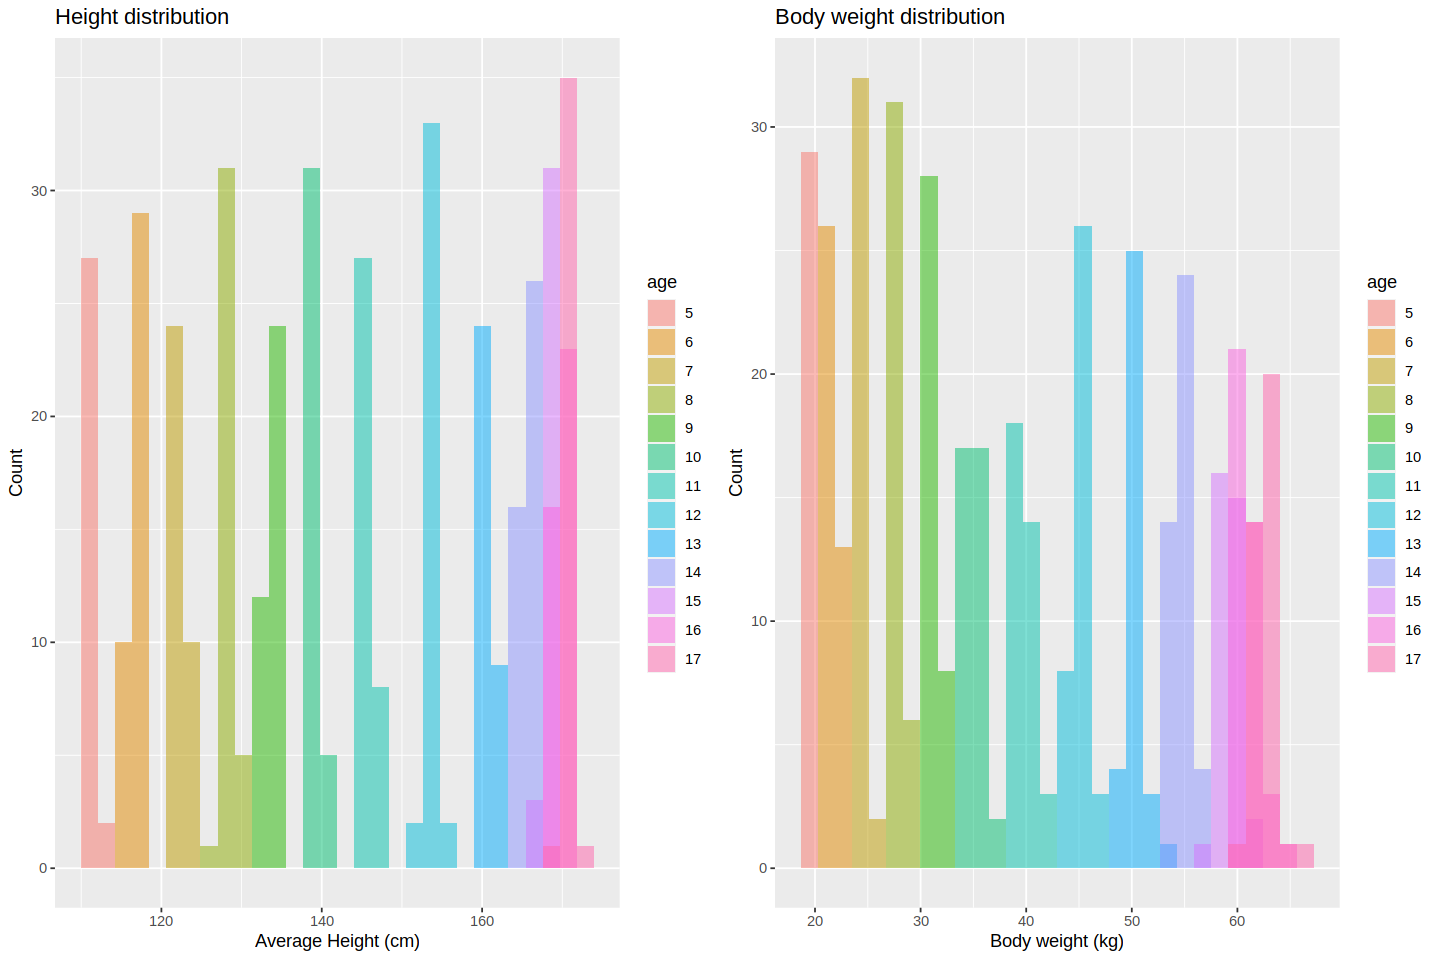

In [77]:
options(repr.plot.width = 12, repr.plot.height = 8)
height_plot <- man_train |>
        ggplot(aes(x = height_average, fill = as_factor(age))) + 
            geom_histogram(alpha = 0.5, position = "identity") + 
            labs(x = "Average Height (cm)", y = "Count", fill = "age") + 
            ggtitle("Height distribution")


body_weight_plot <- man_train |>
        ggplot(aes(x = body_weight_average, fill = as_factor(age))) + 
            geom_histogram(alpha = 0.5, position = "identity") + 
            labs(x = "Body weight (kg)", y = "Count", fill = "age") + 
            ggtitle("Body weight distribution")


training_plot <- plot_grid(height_plot, body_weight_plot, nrow = 1)
training_plot


# Methods

To conduct our analysis, we will read and clean our data, select the weight and height columns for prediction, perform cross-validation, and perform some form of regression to predict age. We will then visualize our results, likely using a scatterplot with a regression line superimposed.

# Expected Outcomes and Significance

By using the height and weight given for a Japanese boy, we can predict the child's age within the given range.

These findings could allow:
- Pediatric Healthcare providers to assess a (Japanese male) child's development and compare it to the average growth patterns as seen in this data set.
- Nutrition and dietary plans for this demographic. If a certain height to weight ratio in other countries produces an average age that differs from this data set.
- Physical Education programs to be tailored to the growth development 

For future questions, would this prediction set be similar for Japanese girls? Could it accurately predict their ages?  Maybe the prepubescent ages might have similar data?
